# Question 2

Using a programming language of your choice, repeat the MLE construction and simulation for AR and MA models as discussed this in the class. 

### Likelihood Function:

**AR(P) Model**: 
$$ X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} + ... + \phi_p X_{t-p} + \epsilon_t $$

Given the observations $ \{ X_t \} $, the residuals (or innovations) can be expressed as:

$$ \epsilon_t = X_t - \sum_{i=1}^{p} \phi_i X_{t-i} $$

Assuming $ \epsilon_t $ is Gaussian, the likelihood function \( L \) for the AR(p) model is:

$$ L(\phi, \sigma^2 | X) = \prod_{t=p+1}^{n} f_{\epsilon}(X_t - \sum_{i=1}^{p} \phi_i X_{t-i}; 0, \sigma^2) $$

Where $ f_{\epsilon} $ is the pdf of the Gaussian distribution.

To simplify the optimization, we use the negative log-likelihood, which converts products into sums:

$$ -\ln L(\phi, \sigma^2 | X) = const + \frac{n-p}{2} \ln(\sigma^2) + \frac{1}{2\sigma^2} \sum_{t=p+1}^{n} (X_t - \sum_{i=1}^{p} \phi_i X_{t-i})^2 $$

The objective is to minimize this function with respect to $ \phi $ and $ \sigma^2 $.

**MA(q) Model**:
$$ X_t = \epsilon_t + \theta_1 \epsilon_{t-1} + ... + \theta_q \epsilon_{t-q} $$

The residuals can be calculated as:

$$\epsilon_t = X_t - \sum_{i=1}^{q} \theta_i \epsilon_{t-i} $$

The likelihood function for the MA(q) model is similar to the AR(p) model, but the way we compute residuals is different due to the nature of the MA process.

Again, we use the negative log-likelihood to convert the product into sums:

$$ -\ln L(\theta, \sigma^2 | X) = const + \frac{n-q}{2} \ln(\sigma^2) + \frac{1}{2\sigma^2} \sum_{t=q+1}^{n} (X_t - \sum_{i=1}^{q} \theta_i \epsilon_{t-i})^2 $$

This function is minimized with respect to $ \theta $ and $ \sigma^2 $.


### Create Test Dataset

In [1]:
import numpy as np
import statsmodels.api as sm
from scipy.optimize import minimize

np.random.seed(42)
n = 1000

# AR(2) parameters
phi_true = np.array([0.5, -0.3])
epsilon_ar = np.random.normal(0, 1, n)
X_ar = np.zeros(n)
for t in range(2, n):
    X_ar[t] = np.dot(phi_true, X_ar[t-2:t][::-1]) + epsilon_ar[t]

# MA(2) parameters
theta_true = np.array([0.4, 0.2])
epsilon_ma = np.random.normal(0, 1, n)
X_ma = np.zeros(n)
for t in range(2, n):
    X_ma[t] = epsilon_ma[t] + np.dot(theta_true, epsilon_ma[t-2:t][::-1])


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### MLE Construction

In [2]:
# AR(p) MLE estimation
def neg_log_likelihood_arp(params, p, data):
    phi = params[:p]
    sigma2 = params[-1]
    lagged_values = sm.tsa.lagmat(data, maxlag=p)[:, :p][p:]
    residuals = data[p:] - np.dot(lagged_values, phi)
    loglik = -0.5 * (len(data)-p) * np.log(2 * np.pi) - 0.5 * (len(data)-p) * np.log(sigma2) - (1/(2 * sigma2)) * np.sum(residuals**2)
    return -loglik

# MA(q) MLE estimation
def neg_log_likelihood_ma(params, q, data):
    theta = params[:q]
    sigma2 = params[-1]
    residuals = np.zeros_like(data)
    epsilon = np.zeros_like(data)
    for t in range(q, len(data)):
        epsilon[t] = data[t] - np.dot(theta, epsilon[t-q:t][::-1])
        residuals[t] = data[t] - np.dot(theta, residuals[t-q:t][::-1])
    loglik = -0.5 * (len(data)-q) * np.log(2 * np.pi) - 0.5 * (len(data)-q) * np.log(sigma2) - (1/(2 * sigma2)) * np.sum(residuals[q:]**2)
    return -loglik

### Evaluation

In [3]:
p = 2
q = 2

# Manual AR(p) Estimation
result_arp = minimize(neg_log_likelihood_arp, [0.5]*p + [1], args=(p, X_ar), method='L-BFGS-B')
phi_hats = result_arp.x[:-1]

# AR(p) using statsmodels
model_ar_statsmodels = sm.tsa.ARIMA(X_ar, order=(p, 0, 0)).fit()
phi_statsmodels = model_ar_statsmodels.params[1:-1]
sigma2_statsmodels_ar = np.var(model_ar_statsmodels.resid)

print(f"AR({p}) Manual Estimation: phi_hats={phi_hats}")
print(f"AR({p}) Statsmodels Estimation: phi_hats={phi_statsmodels}, sigma2={sigma2_statsmodels_ar:.4f}")

# Manual MA(q) Estimation
result_ma = minimize(neg_log_likelihood_ma, [0.5]*q + [1], args=(q, X_ma), method='L-BFGS-B')
theta_hats = result_ma.x[:-1]

# MA(q) using statsmodels
model_ma_statsmodels = sm.tsa.ARIMA(X_ma, order=(0, 0, q)).fit()
theta_statsmodels = model_ma_statsmodels.params[1:-1]
sigma2_statsmodels_ma = np.var(model_ma_statsmodels.resid)

print(f"\nMA({q}) Manual Estimation: theta_hats={theta_hats}")
print(f"MA({q}) Statsmodels Estimation: theta_hats={theta_statsmodels}, sigma2={sigma2_statsmodels_ma:.4f}")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
AR(2) Manual Estimation: phi_hats=[ 0.49841009 -0.29649538]
AR(2) Statsmodels Estimation: phi_hats=[ 0.49765488 -0.29616985], sigma2=0.9576
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

MA(2) Manual Estimation: theta_hats=[0.38297593 0.17760144]
MA(2) Statsmodels Estimation: theta_hats=[0.37869661 0.17325562], sigma2=0.9909


# Question 3

For the time series model below:
$$X_t = 0.9X_{t-1} + Z_t$$ 
Zt is N(0,0.72)

## (i) Simulate a path with 1000 data points

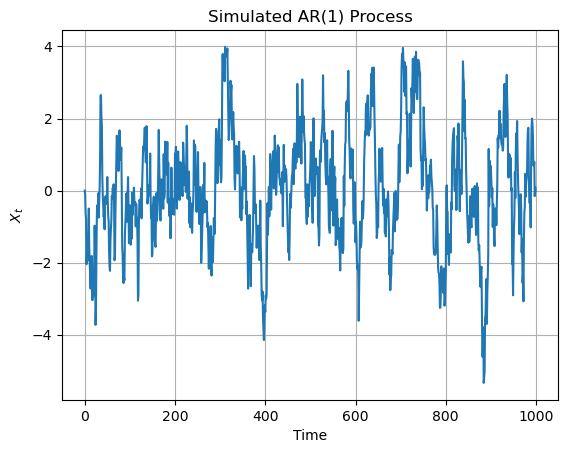

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
phi = 0.9
sigma = 0.7
T = 1000

# Initialize
X = np.zeros(T)
Z = np.random.normal(0, sigma, T)

# Simulate the AR(1) process
for t in range(1, T):
    X[t] = phi * X[t-1] + Z[t]

# Plot the simulated data
plt.plot(X)
plt.title("Simulated AR(1) Process")
plt.xlabel("Time")
plt.ylabel("$X_t$")
plt.grid(True)
plt.show()


## (ii) Estimate the parameters using the MLE estimator

In [5]:
import numpy as np
from statsmodels.tsa.tsatools import lagmat
from scipy.optimize import minimize

# Estimate AR(1) parameters
p = 1  # AR order
initial_guess = [0.5] * p + [0.5]  # Initial guess for phi and sigma2
bounds = [([-1, 1] if i < p else (0, None)) for i in range(p+1)]
result = minimize(neg_log_likelihood_arp, initial_guess, args=(p, X), bounds=bounds)

phi_hat = result.x[:p]
sigma2_hat = result.x[-1]
print(f"Estimated phi: {phi_hat[0]:.4f}")
print(f"Estimated sigma^2: {sigma2_hat:.4f}")


Estimated phi: 0.8981
Estimated sigma^2: 0.4737


## (iii) Distribution and 95% confidence levels for mean estimated parameters

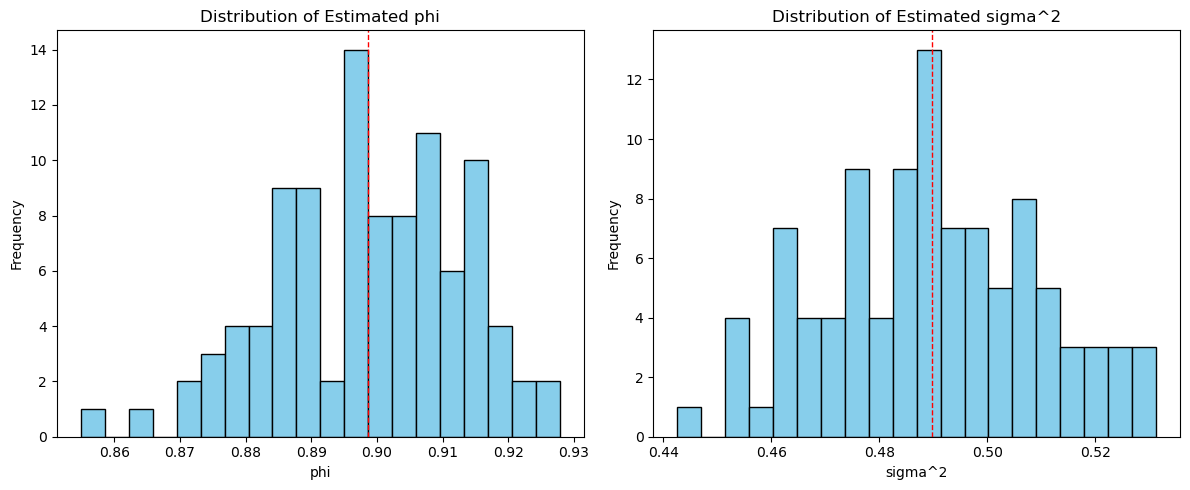

95% confidence interval for phi: (0.8712612352236218, 0.9214638867344682)
95% confidence interval for sigma^2: (0.45532508582315256, 0.5267221288595942)


In [10]:
import numpy as np
from statsmodels.tsa.tsatools import lagmat
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def neg_log_likelihood_arp(params, p, data):
    phi = params[:p]
    sigma2 = params[-1] + 1e-6  # Add a small positive offset to avoid log(0)
    lagged_values = lagmat(data, maxlag=p)[:, :p][p:]
    residuals = data[p:] - np.dot(lagged_values, phi)
    loglik = -0.5 * (len(data)-p) * np.log(2 * np.pi) - 0.5 * (len(data)-p) * np.log(sigma2) - (1/(2 * sigma2)) * np.sum(residuals**2)
    return -loglik

phi_true = 0.9
sigma_true = 0.7
T = 1000
iterations = 100

phi_estimates = []
sigma2_estimates = []

for _ in range(iterations):
    X = np.zeros(T)
    Z = np.random.normal(0, sigma_true, T)
    for t in range(1, T):
        X[t] = phi_true * X[t-1] + Z[t]

    p = 1  # AR order
    initial_guess = [0.5] * p + [0.5]
    bounds = [([-1, 1] if i < p else (0, None)) for i in range(p+1)]
    result = minimize(neg_log_likelihood_arp, initial_guess, args=(p, X), bounds=bounds)
    
    phi_estimates.append(result.x[0])
    sigma2_estimates.append(result.x[-1])

# Plot histograms
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(phi_estimates, bins=20, color='skyblue', edgecolor='black')
plt.axvline(np.mean(phi_estimates), color='r', linestyle='dashed', linewidth=1)
plt.title('Distribution of Estimated phi')
plt.xlabel('phi')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(sigma2_estimates, bins=20, color='skyblue', edgecolor='black')
plt.axvline(np.mean(sigma2_estimates), color='r', linestyle='dashed', linewidth=1)
plt.title('Distribution of Estimated sigma^2')
plt.xlabel('sigma^2')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Compute 95% confidence intervals
phi_ci = (np.percentile(phi_estimates, 2.5), np.percentile(phi_estimates, 97.5))
sigma2_ci = (np.percentile(sigma2_estimates, 2.5), np.percentile(sigma2_estimates, 97.5))
print(f"95% confidence interval for phi: {phi_ci}")
print(f"95% confidence interval for sigma^2: {sigma2_ci}")


## (iv) Increase simulation times

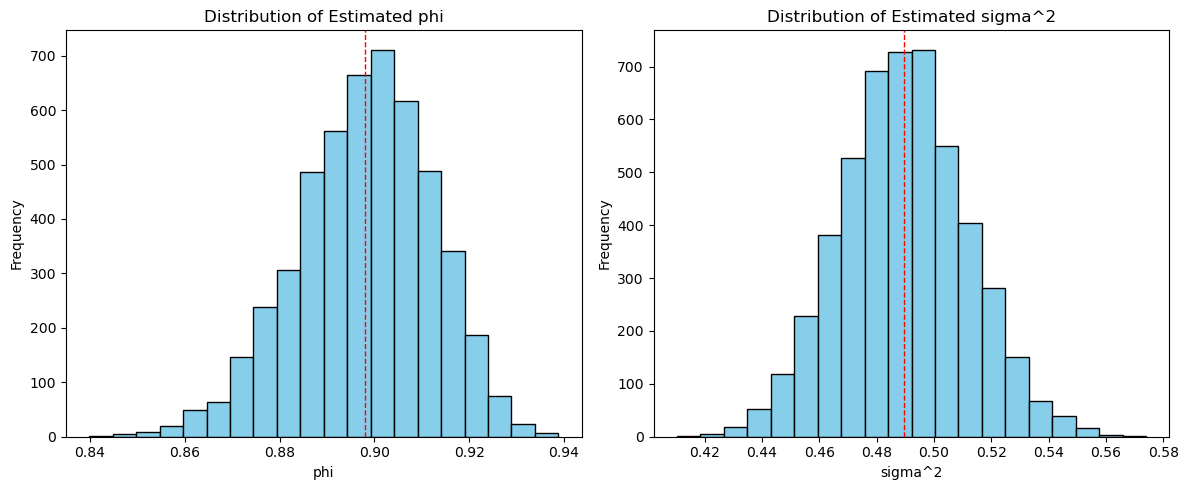

95% confidence interval for phi: (0.8681249314723096, 0.9231769903356609)
95% confidence interval for sigma^2: (0.4465266540494144, 0.5331687299157949)


In [11]:
phi_true = 0.9
sigma_true = 0.7
T = 1000
iterations = 5000

phi_estimates = []
sigma2_estimates = []

for _ in range(iterations):
    X = np.zeros(T)
    Z = np.random.normal(0, sigma_true, T)
    for t in range(1, T):
        X[t] = phi_true * X[t-1] + Z[t]

    p = 1  # AR order
    initial_guess = [0.5] * p + [0.5]
    bounds = [([-1, 1] if i < p else (0, None)) for i in range(p+1)]
    result = minimize(neg_log_likelihood_arp, initial_guess, args=(p, X), bounds=bounds)
    
    phi_estimates.append(result.x[0])
    sigma2_estimates.append(result.x[-1])

# Plot histograms
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(phi_estimates, bins=20, color='skyblue', edgecolor='black')
plt.axvline(np.mean(phi_estimates), color='r', linestyle='dashed', linewidth=1)
plt.title('Distribution of Estimated phi')
plt.xlabel('phi')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(sigma2_estimates, bins=20, color='skyblue', edgecolor='black')
plt.axvline(np.mean(sigma2_estimates), color='r', linestyle='dashed', linewidth=1)
plt.title('Distribution of Estimated sigma^2')
plt.xlabel('sigma^2')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Compute 95% confidence intervals
phi_ci = (np.percentile(phi_estimates, 2.5), np.percentile(phi_estimates, 97.5))
sigma2_ci = (np.percentile(sigma2_estimates, 2.5), np.percentile(sigma2_estimates, 97.5))
print(f"95% confidence interval for phi: {phi_ci}")
print(f"95% confidence interval for sigma^2: {sigma2_ci}")